Author: Rizal Mujahiddan

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display

from itertools import combinations

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTENC,SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer,KElbowVisualizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


pd.options.display.float_format = '{:.2f}'.format

# Load Dataset

In [3]:
loan_df = pd.read_csv('/kaggle/input/rakamin-digifest-2024/loan_customer.csv')
display(loan_df.dtypes)
display(loan_df.head())

loan_id                object
birth_date             object
phone_number          float64
gender                 object
married                object
dependents             object
education              object
self_employed          object
applicant_income      float64
coapplicant_income    float64
loan_amount             int64
loan_term_month         int64
loan_term_year          int64
credit_history        float64
has_credit_card        object
property_type          object
loan_status            object
dtype: object

,loan_id,birth_date,phone_number,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
0,LP001002,1977-05-15,628114203187.00,Male,No,0,Graduate,No,5849.00,0.00,100000,360,30,1.00,NaN,house,APPROVE
1,LP001003,1979-08-24,628776449212.00,Male,Yes,1,Graduate,No,4583.00,1508.00,128000,360,30,1.00,NaN,studio,REJECT
2,LP001005,1991-03-28,628119240537.00,Male,Yes,0,Graduate,Yes,3000.00,0.00,66000,360,30,1.00,NaN,house,APPROVE
3,LP001006,1980-06-02,62856343702.00,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120000,360,30,1.00,NaN,house,APPROVE
4,LP001008,1989-05-19,628113008687.00,Male,No,0,Graduate,No,6000.00,0.00,141000,360,30,1.00,NaN,house,APPROVE


# EDA

## Statistics Description

In [4]:
loan_df.describe().T

,count,mean,std,min,25%,50%,75%,max
phone_number,569.00,546855215520.82,198786011216.07,62811008895.00,628113971569.00,628134297140.00,628566524301.00,628779851264.00
applicant_income,612.00,5681.55,9056.45,150.00,2874.50,3812.50,5815.75,170578.00
coapplicant_income,621.00,1616.87,2915.08,0.00,0.00,1167.00,2302.00,41667.00
loan_amount,621.00,145133.66,84011.12,9000.00,100000.00,125000.00,165000.00,700000.00
loan_term_month,621.00,342.61,64.09,12.00,360.00,360.00,360.00,480.00
loan_term_year,621.00,28.55,5.34,1.00,30.00,30.00,30.00,40.00
credit_history,570.00,0.84,0.36,0.00,1.00,1.00,1.00,1.00


## Check Missing Value

In [5]:
col_isna_sort = loan_df.isna().sum().sort_values(ascending=False).index.tolist()
loan_df_miss = loan_df[col_isna_sort]
loan_df_miss = loan_df_miss.sort_values(col_isna_sort)
loan_df_miss.head()

,has_credit_card,phone_number,credit_history,birth_date,self_employed,dependents,gender,applicant_income,married,education,property_type,loan_term_year,loan_id,loan_term_month,loan_amount,coapplicant_income,loan_status
261,no,62811984416.00,NaN,1989-09-11,No,1,Male,6083.00,Yes,Graduate,house,30,LP001865,360,330000,4250.00,APPROVE
471,no,62811996436.00,0.00,1987-04-07,No,3+,Male,2947.00,Yes,Not Graduate,house,15,LP002500,180,70000,1664.00,REJECT
146,no,62813861511.00,1.00,1981-10-20,No,0,Female,2330.00,Yes,Graduate,apartment,30,LP001514,360,100000,4486.00,APPROVE
114,no,62852104763.00,1.00,1986-03-28,Yes,1,Female,7451.00,No,Graduate,apartment,30,LP001392,360,126000,0.00,APPROVE
28,no,62852216764.00,1.00,1978-11-21,No,0,Male,1442.00,No,Not Graduate,house,30,LP001086,360,35000,0.00,REJECT


<Axes: >

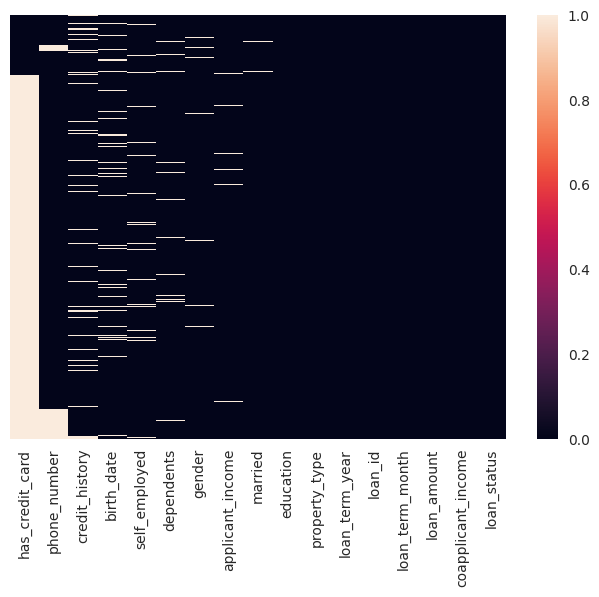

In [6]:
sns.heatmap(loan_df_miss.isnull(),
            yticklabels=False
           )

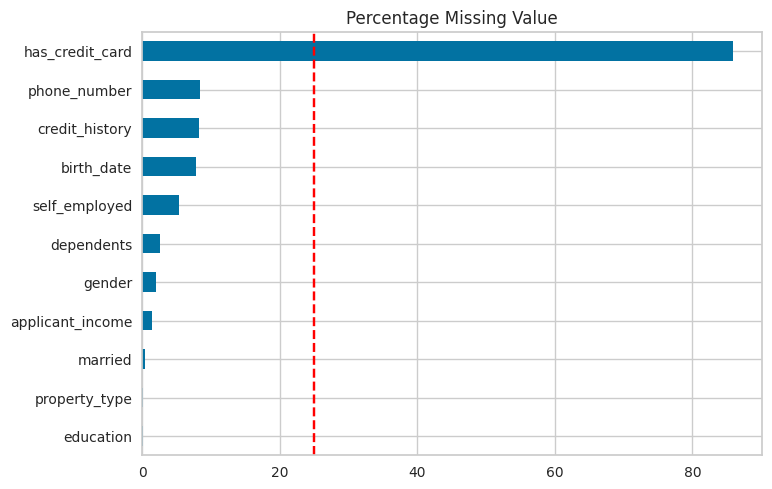

In [7]:
loan_miss = loan_df.isna().sum()
loan_miss = loan_miss[loan_miss!=0]
loan_miss = loan_miss.sort_values()
loan_miss = loan_miss / loan_df.shape[0] * 100

loan_miss.plot(kind='barh',)
plt.axvline(25,linestyle='--',color='red')
plt.title('Percentage Missing Value')
plt.show()

## Univariate Plot

### Categorical

<Axes: xlabel='gender', ylabel='count'>

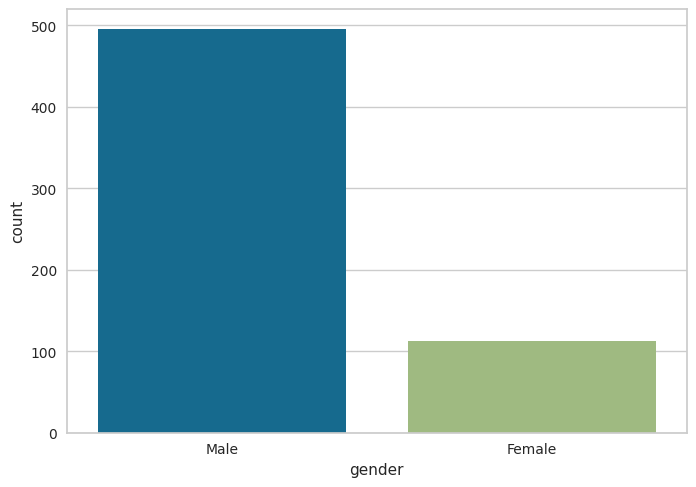

In [8]:
sns.countplot(loan_df,x='gender')

<Axes: xlabel='married', ylabel='count'>

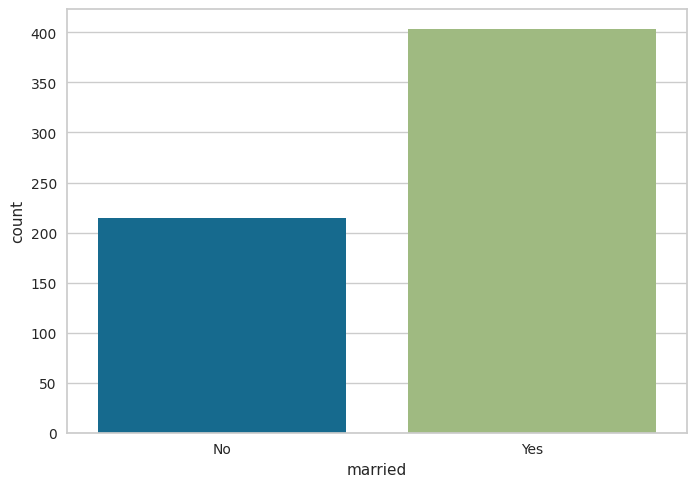

In [9]:
sns.countplot(loan_df,x='married')

<Axes: xlabel='dependents', ylabel='count'>

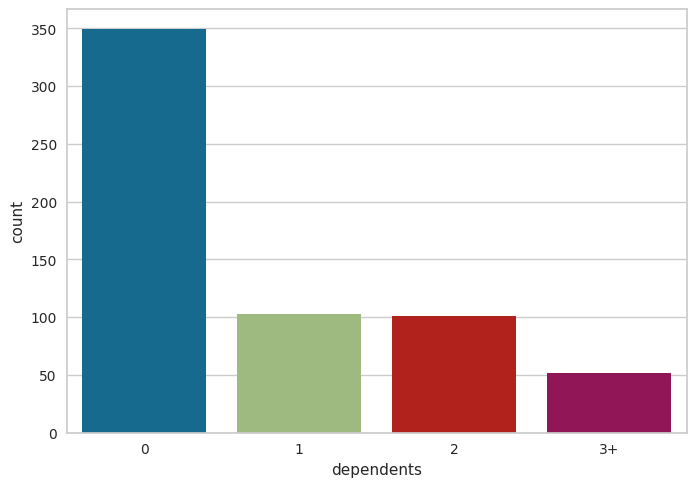

In [10]:
sns.countplot(loan_df,x='dependents')

<Axes: xlabel='education', ylabel='count'>

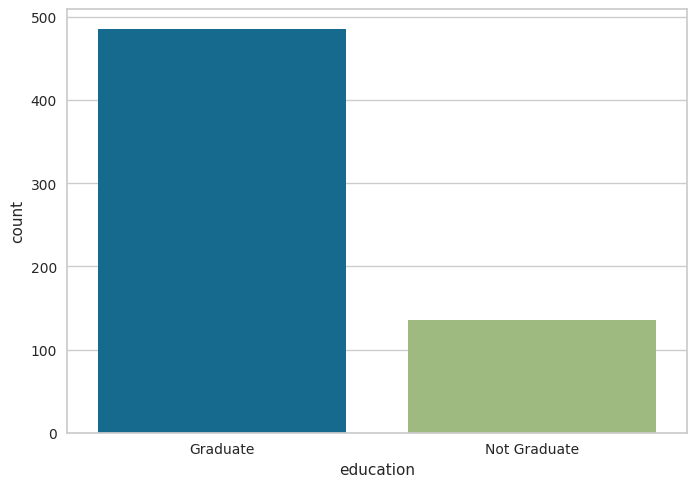

In [11]:
sns.countplot(loan_df,x='education')

<Axes: xlabel='self_employed', ylabel='count'>

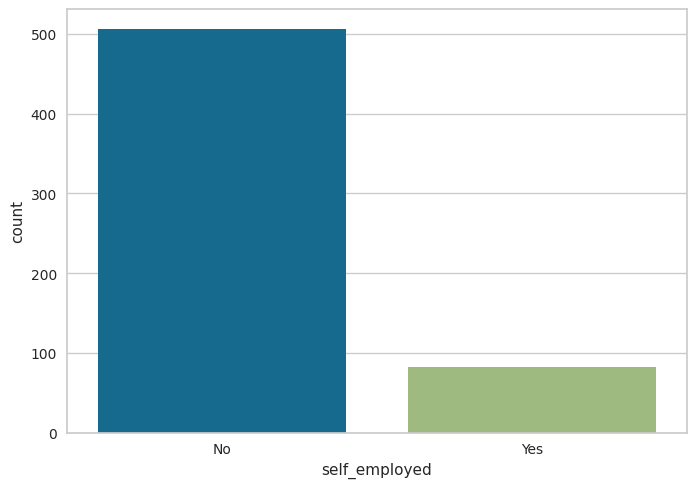

In [12]:
sns.countplot(loan_df,x='self_employed')

<Axes: xlabel='property_type', ylabel='count'>

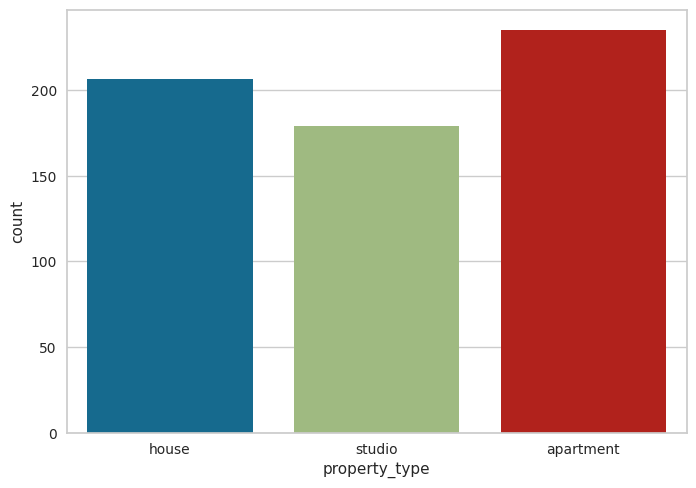

In [13]:
sns.countplot(loan_df,x='property_type')

<Axes: xlabel='loan_status', ylabel='count'>

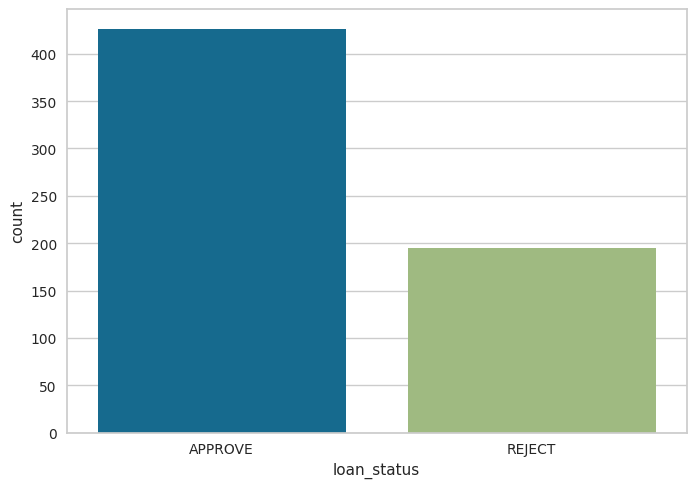

In [14]:
sns.countplot(loan_df,x='loan_status')

### Numeric

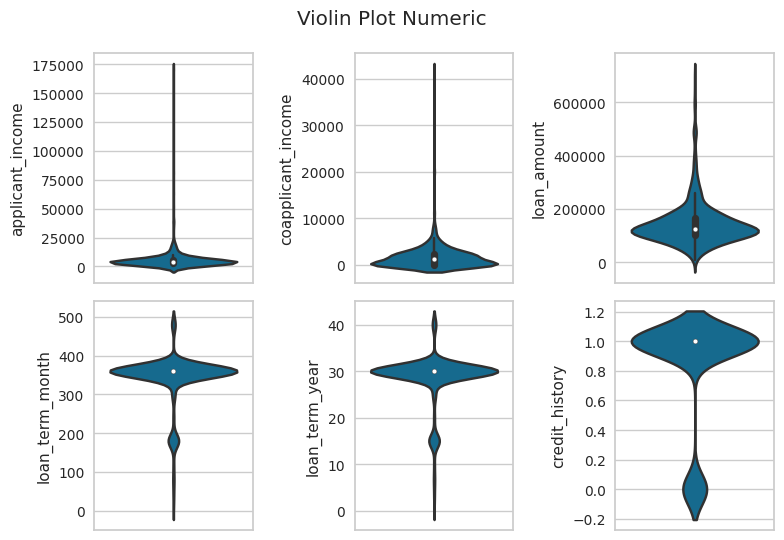

In [15]:
num_col = loan_df.select_dtypes(include='number').columns.tolist()
num_col.remove('phone_number')

fig,ax = plt.subplots(nrows=2,ncols=3)
for i,col in enumerate(num_col):
    ii = i // 3
    jj = i %  3
    sns.violinplot(loan_df,y=col,ax=ax[ii][jj])

plt.suptitle('Violin Plot Numeric')
plt.tight_layout()
plt.show()

## Target Categorical

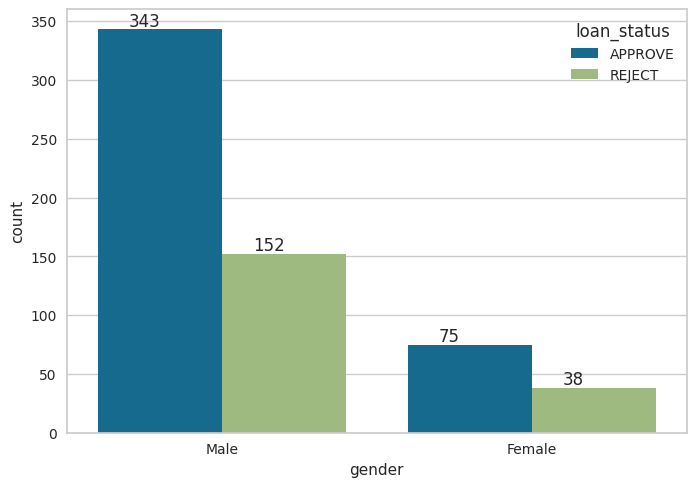

In [16]:
ax = sns.countplot(loan_df,
              x='gender',
              hue='loan_status'
             )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )
plt.show()

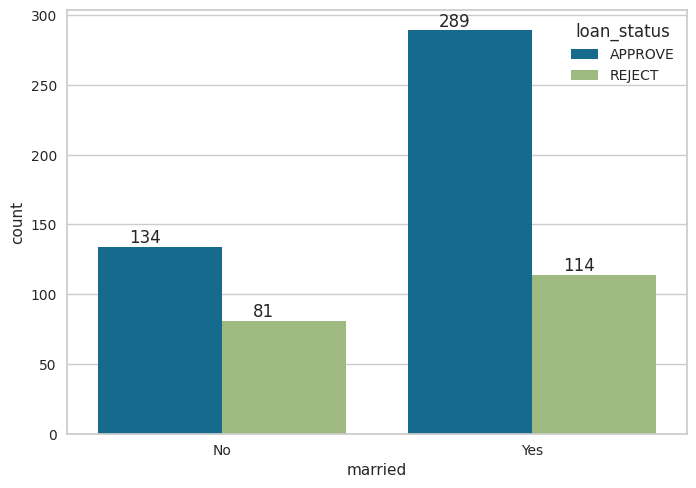

In [17]:
ax = sns.countplot(loan_df,
              x='married',
              hue='loan_status'
             )
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )
plt.show()

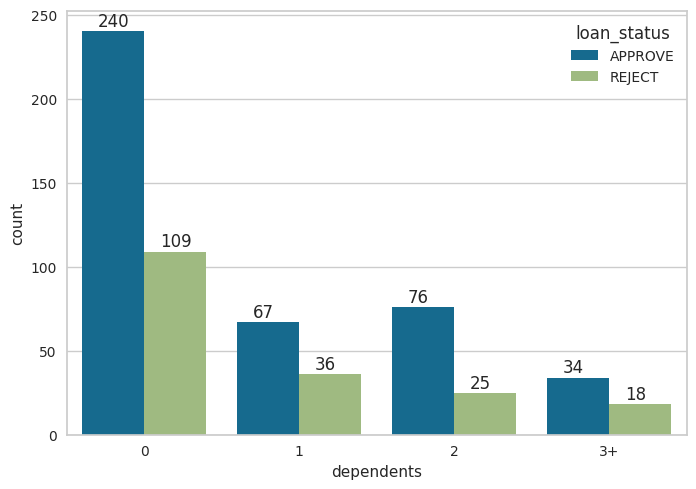

In [18]:
ax = sns.countplot(loan_df,
              x='dependents',
              hue='loan_status'
             )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )
plt.show()

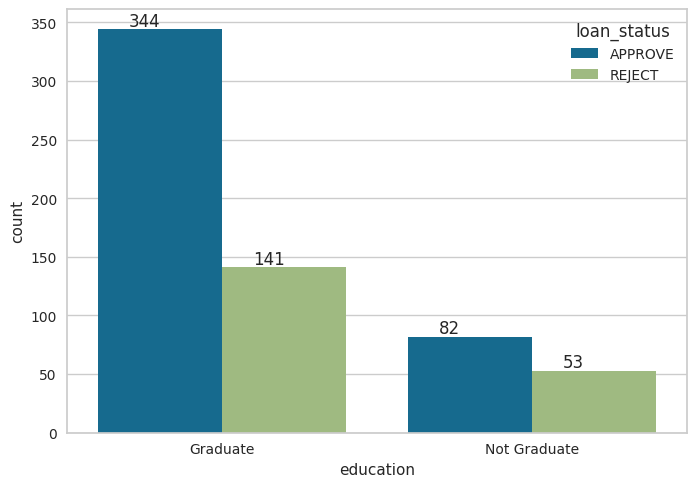

In [19]:
ax = sns.countplot(loan_df,
              x='education',
              hue='loan_status'
             )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )

plt.show()

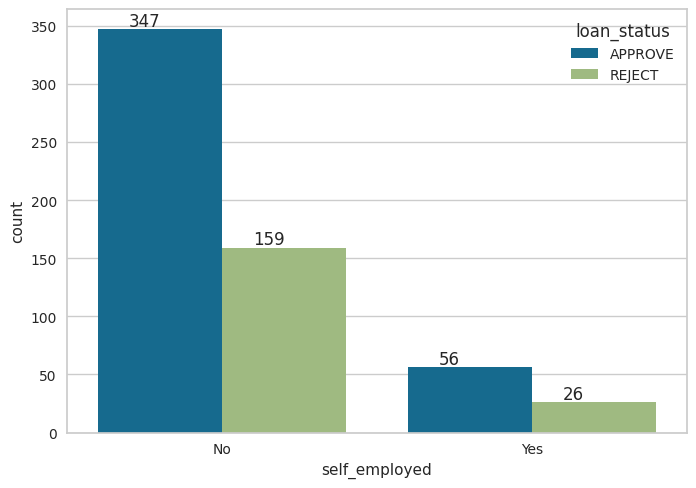

In [20]:
ax = sns.countplot(loan_df,
              x='self_employed',
              hue='loan_status'
             )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )

plt.show()

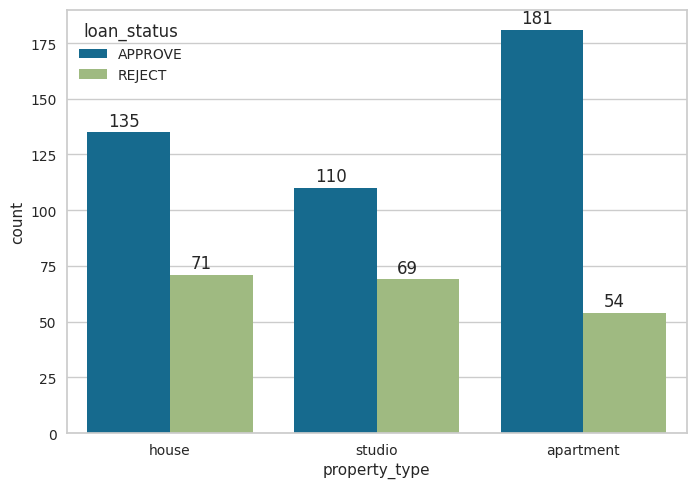

In [21]:
ax = sns.countplot(loan_df,
              x='property_type',
              hue='loan_status'
             )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.1, p.get_height()+3)
               )

plt.show()

## PairPlot

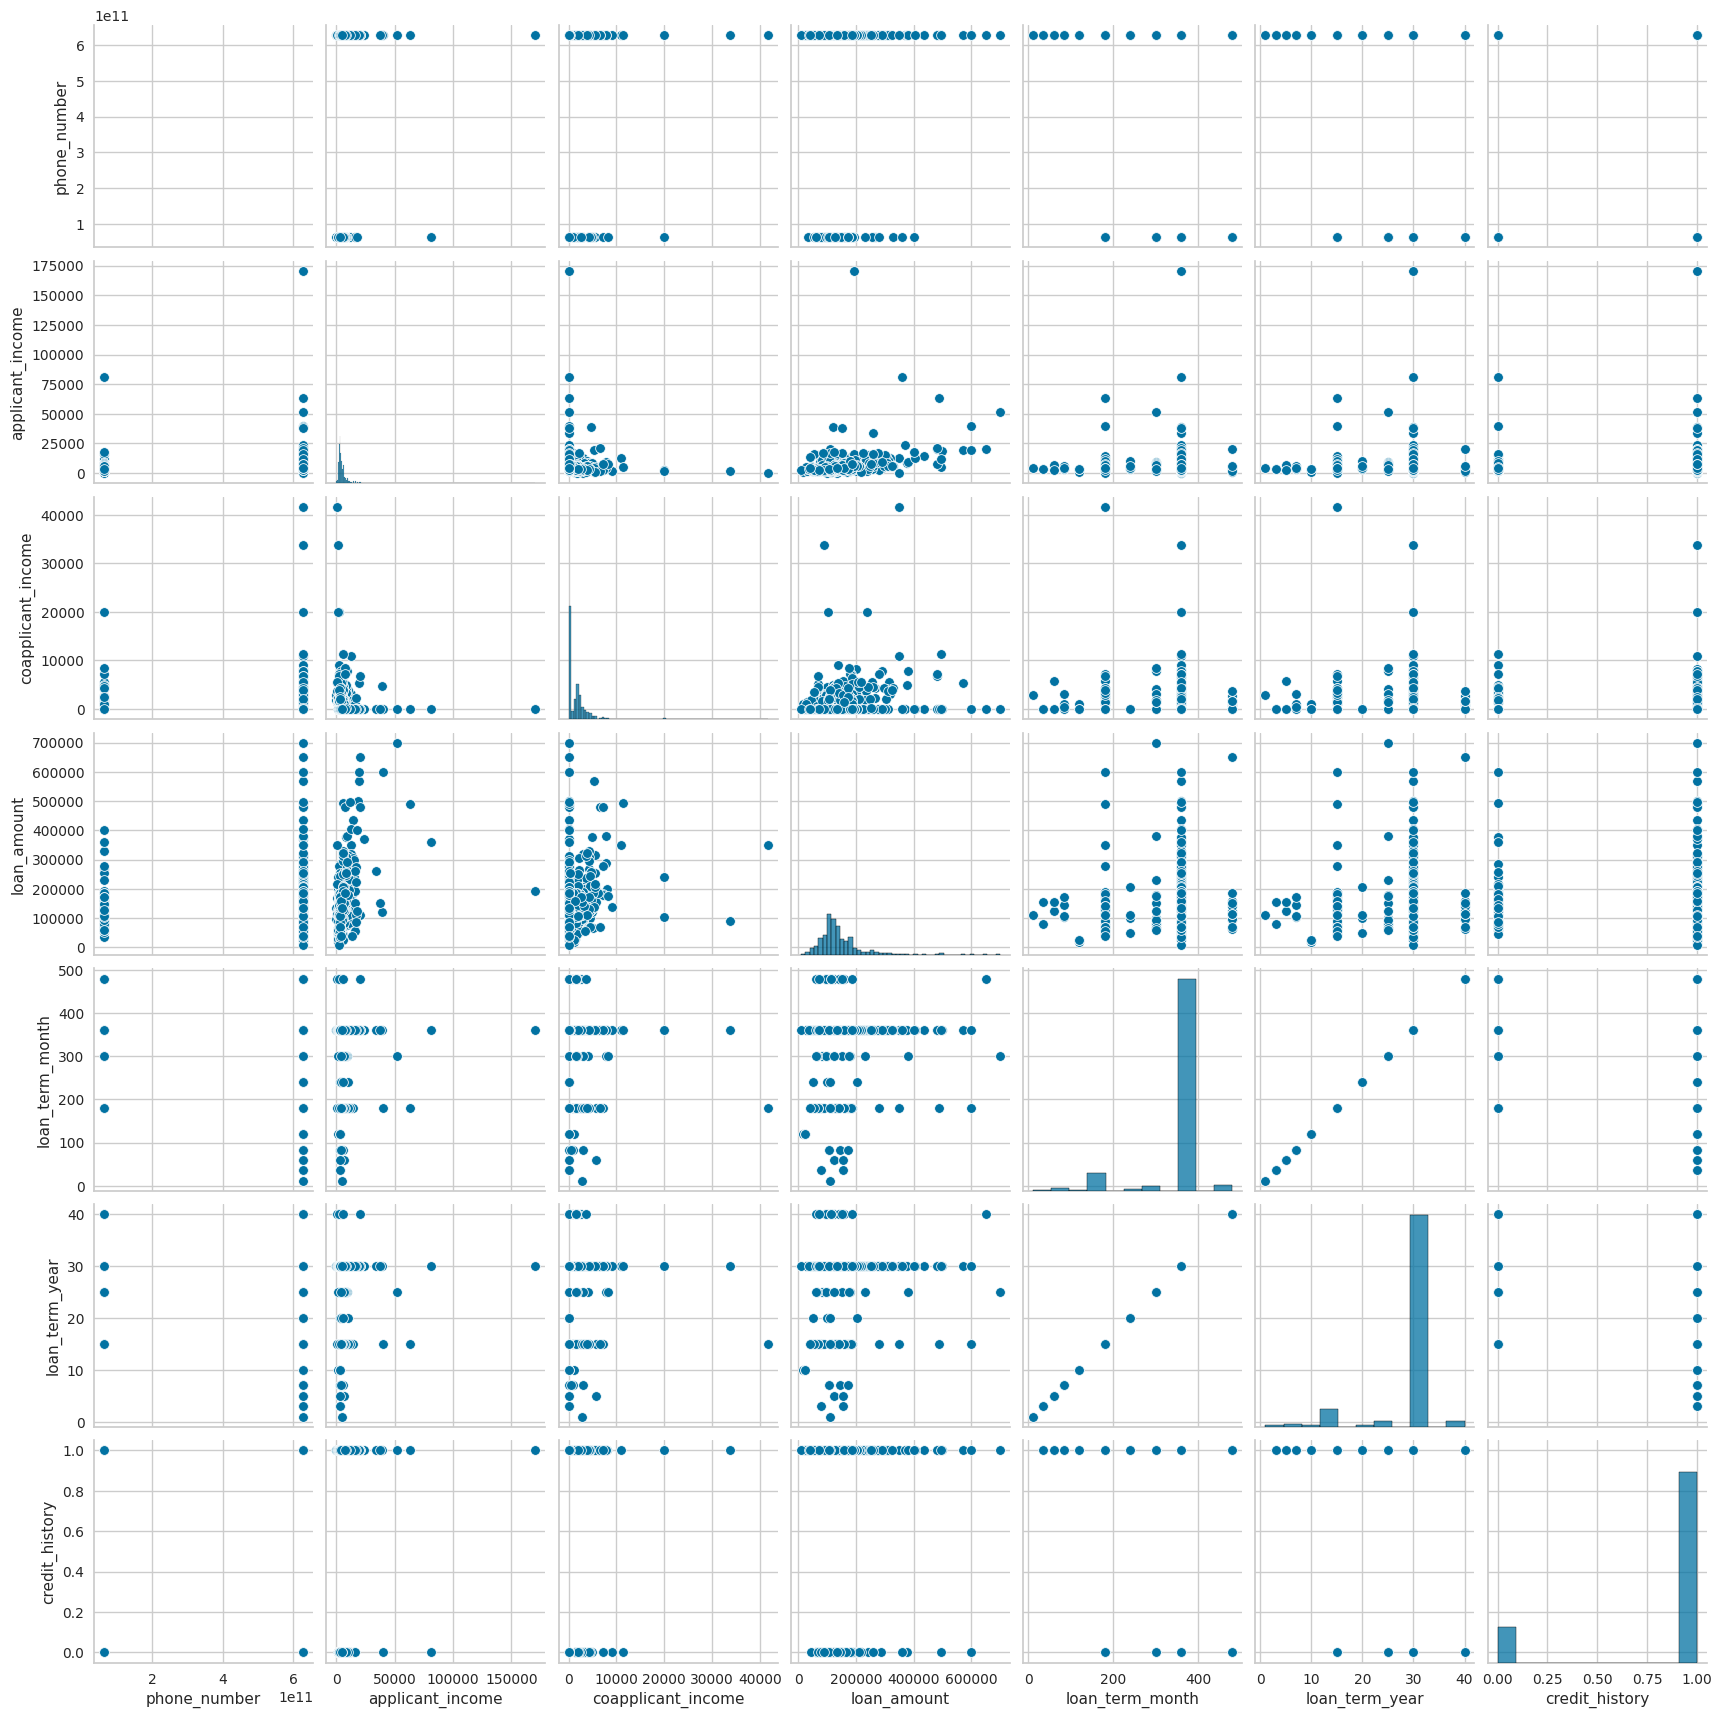

In [22]:
sns.pairplot(loan_df)
plt.show()

## Correlation Heatmap

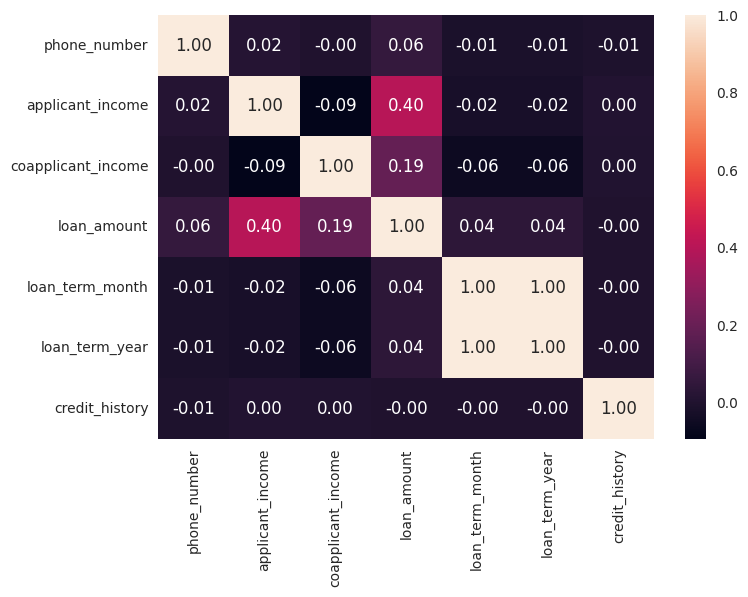

In [23]:
sns.heatmap(loan_df.select_dtypes(include='number').corr(),
            fmt='.2f',
            annot=True
            )
plt.show()

# Data Cleansing

## Repairing Datatype

In [24]:
display(loan_df.head(5))
display(loan_df.dtypes)

,loan_id,birth_date,phone_number,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
0,LP001002,1977-05-15,628114203187.00,Male,No,0,Graduate,No,5849.00,0.00,100000,360,30,1.00,NaN,house,APPROVE
1,LP001003,1979-08-24,628776449212.00,Male,Yes,1,Graduate,No,4583.00,1508.00,128000,360,30,1.00,NaN,studio,REJECT
2,LP001005,1991-03-28,628119240537.00,Male,Yes,0,Graduate,Yes,3000.00,0.00,66000,360,30,1.00,NaN,house,APPROVE
3,LP001006,1980-06-02,62856343702.00,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120000,360,30,1.00,NaN,house,APPROVE
4,LP001008,1989-05-19,628113008687.00,Male,No,0,Graduate,No,6000.00,0.00,141000,360,30,1.00,NaN,house,APPROVE


loan_id                object
birth_date             object
phone_number          float64
gender                 object
married                object
dependents             object
education              object
self_employed          object
applicant_income      float64
coapplicant_income    float64
loan_amount             int64
loan_term_month         int64
loan_term_year          int64
credit_history        float64
has_credit_card        object
property_type          object
loan_status            object
dtype: object

In [25]:
loan_df.birth_date = pd.to_datetime(loan_df.birth_date,
                                    format='%Y-%m-%d',
                                   )
loan_df.birth_date

0     1977-05-15
1     1979-08-24
2     1991-03-28
3     1980-06-02
4     1989-05-19
         ...    
616   1976-03-25
617   1987-01-26
618   1982-03-08
619   1986-12-05
620          NaT
Name: birth_date, Length: 621, dtype: datetime64[ns]

In [26]:
loan_df.loan_id = loan_df.loan_id.astype('str')
loan_df

,loan_id,birth_date,phone_number,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
0,LP001002,1977-05-15,628114203187.00,Male,No,0,Graduate,No,5849.00,0.00,100000,360,30,1.00,NaN,house,APPROVE
1,LP001003,1979-08-24,628776449212.00,Male,Yes,1,Graduate,No,4583.00,1508.00,128000,360,30,1.00,NaN,studio,REJECT
2,LP001005,1991-03-28,628119240537.00,Male,Yes,0,Graduate,Yes,3000.00,0.00,66000,360,30,1.00,NaN,house,APPROVE
3,LP001006,1980-06-02,62856343702.00,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120000,360,30,1.00,NaN,house,APPROVE
4,LP001008,1989-05-19,628113008687.00,Male,No,0,Graduate,No,6000.00,0.00,141000,360,30,1.00,NaN,house,APPROVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,LP002978,1976-03-25,628564969545.00,Female,No,0,Graduate,No,2900.00,0.00,71000,360,30,1.00,NaN,studio,APPROVE
617,LP002979,1987-01-26,628116531578.00,Male,Yes,3+,Graduate,No,4106.00,0.00,40000,180,15,1.00,NaN,studio,APPROVE
618,LP002983,1982-03-08,628115828430.00,Male,Yes,1,Graduate,No,8072.00,240.00,253000,360,30,1.00,NaN,house,APPROVE
619,LP002984,1986-12-05,628119590176.00,Male,Yes,2,Graduate,No,7583.00,0.00,187000,360,30,1.00,NaN,house,APPROVE


## Handling missing values

In [27]:
missing_series = loan_df.isna().sum()
missing_series = missing_series[missing_series!=0]
missing_series = missing_series.sort_values()
missing_list = missing_series.index.tolist()

comb_col = list(combinations(missing_list,2))

display(missing_series)
print(missing_list)

education             1
property_type         1
married               3
applicant_income      9
gender               13
dependents           16
self_employed        33
birth_date           49
credit_history       51
phone_number         52
has_credit_card     533
dtype: int64

['education', 'property_type', 'married', 'applicant_income', 'gender', 'dependents', 'self_employed', 'birth_date', 'credit_history', 'phone_number', 'has_credit_card']


### Checking MCAR

In [28]:
# Create missingness indicator variables
loan_df_miss = pd.DataFrame()
non_mcar = []
for a_col,b_col in comb_col:
    loan_df_miss[f'{a_col}_miss'] = loan_df[a_col].isnull().astype(int)
    loan_df_miss[f'{b_col}_miss'] = loan_df[b_col].isnull().astype(int)

    # Perform chi-squared test to check independence
    chi2, p, _, _ = chi2_contingency(pd.crosstab(loan_df_miss[f'{a_col}_miss'], loan_df_miss[f'{b_col}_miss']))
    if p < 0.05:
        print(f"MCAR hypothesis rejected     : {a_col} <-> {b_col}")
        non_mcar.append(a_col)
        non_mcar.append(b_col)
    #else:
        #print(f"MCAR hypothesis not rejected : {a_col} <-> {b_col}")
non_mcar_set = set(non_mcar)
missing_set = set(missing_list)
mcar_set = missing_set - non_mcar_set
print()
print('Non-MCAR Columns')
print(non_mcar_set)
print()
print('MCAR Columns')
print(mcar_set)

MCAR hypothesis rejected     : education <-> property_type
MCAR hypothesis rejected     : education <-> dependents
MCAR hypothesis rejected     : education <-> self_employed
MCAR hypothesis rejected     : property_type <-> dependents
MCAR hypothesis rejected     : property_type <-> self_employed
MCAR hypothesis rejected     : married <-> applicant_income
MCAR hypothesis rejected     : married <-> dependents
MCAR hypothesis rejected     : self_employed <-> credit_history
MCAR hypothesis rejected     : credit_history <-> has_credit_card

Non-MCAR Columns
{'education', 'credit_history', 'married', 'property_type', 'dependents', 'has_credit_card', 'self_employed', 'applicant_income'}

MCAR Columns
{'phone_number', 'gender', 'birth_date'}


Jadi Saya membuang kolom **has_credit_card** karena terlalu banyak missing value (80%), Saya membuang kolom phone_number karena tidak esensial serta memiliki missing value jadi saya buang

In [29]:
non_mcar_set.remove('has_credit_card')
loan_df = loan_df.drop([#'has_credit_card',
                        'phone_number'],
                       axis=1)
loan_df

,loan_id,birth_date,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
0,LP001002,1977-05-15,Male,No,0,Graduate,No,5849.00,0.00,100000,360,30,1.00,NaN,house,APPROVE
1,LP001003,1979-08-24,Male,Yes,1,Graduate,No,4583.00,1508.00,128000,360,30,1.00,NaN,studio,REJECT
2,LP001005,1991-03-28,Male,Yes,0,Graduate,Yes,3000.00,0.00,66000,360,30,1.00,NaN,house,APPROVE
3,LP001006,1980-06-02,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120000,360,30,1.00,NaN,house,APPROVE
4,LP001008,1989-05-19,Male,No,0,Graduate,No,6000.00,0.00,141000,360,30,1.00,NaN,house,APPROVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,LP002978,1976-03-25,Female,No,0,Graduate,No,2900.00,0.00,71000,360,30,1.00,NaN,studio,APPROVE
617,LP002979,1987-01-26,Male,Yes,3+,Graduate,No,4106.00,0.00,40000,180,15,1.00,NaN,studio,APPROVE
618,LP002983,1982-03-08,Male,Yes,1,Graduate,No,8072.00,240.00,253000,360,30,1.00,NaN,house,APPROVE
619,LP002984,1986-12-05,Male,Yes,2,Graduate,No,7583.00,0.00,187000,360,30,1.00,NaN,house,APPROVE


In [30]:
loan_df['birth_date_day'] = loan_df.birth_date.dt.day
loan_df['birth_date_month'] = loan_df.birth_date.dt.month
loan_df['birth_date_year'] = loan_df.birth_date.dt.year
loan_df = loan_df.drop(['birth_date'],axis=1)

In [31]:
loan_df_no_id = loan_df.drop('loan_id',axis=1)
for nam_col,ser_col in loan_df_no_id.select_dtypes(exclude='number').items():
    un_lev = ser_col.value_counts().index.tolist()
    if(len(un_lev)!=2):
        print(nam_col,un_lev)

dependents ['0', '1', '2', '3+']
property_type ['apartment', 'house', 'studio']


In [32]:
map_gen_str_int = {
    'Male':1,
    'Female':0
}

map_mar_str_int = {
    'Yes':1,
    'No':0
}

map_edu_str_int = {
    'Graduate':1,
    'Not Graduate':0
}

map_self_emp_str_int = {
    'Yes':1,
    'No':0
}

map_cc_str_int = {
    'yes':1,
    'no':0
}

map_loan_str_int = {
    'APPROVE':1,
    'REJECT':0
}

loan_df_no_id.has_credit_card = loan_df_no_id.has_credit_card.replace(map_cc_str_int)
loan_df_no_id.gender = loan_df_no_id.gender.replace(map_gen_str_int)
loan_df_no_id.married = loan_df_no_id.married.replace(map_mar_str_int)
loan_df_no_id.education = loan_df_no_id.education.replace(map_edu_str_int)
loan_df_no_id.self_employed = loan_df_no_id.self_employed.replace(map_self_emp_str_int)
loan_df_no_id.loan_status = loan_df_no_id.loan_status.replace(map_loan_str_int)
loan_df_no_id

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status,birth_date_day,birth_date_month,birth_date_year
0,1.00,0.00,0,1.00,0.00,5849.00,0.00,100000,360,30,1.00,NaN,house,1,15.00,5.00,1977.00
1,1.00,1.00,1,1.00,0.00,4583.00,1508.00,128000,360,30,1.00,NaN,studio,0,24.00,8.00,1979.00
2,1.00,1.00,0,1.00,1.00,3000.00,0.00,66000,360,30,1.00,NaN,house,1,28.00,3.00,1991.00
3,1.00,1.00,0,0.00,0.00,2583.00,2358.00,120000,360,30,1.00,NaN,house,1,2.00,6.00,1980.00
4,1.00,0.00,0,1.00,0.00,6000.00,0.00,141000,360,30,1.00,NaN,house,1,19.00,5.00,1989.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,0.00,0.00,0,1.00,0.00,2900.00,0.00,71000,360,30,1.00,NaN,studio,1,25.00,3.00,1976.00
617,1.00,1.00,3+,1.00,0.00,4106.00,0.00,40000,180,15,1.00,NaN,studio,1,26.00,1.00,1987.00
618,1.00,1.00,1,1.00,0.00,8072.00,240.00,253000,360,30,1.00,NaN,house,1,8.00,3.00,1982.00
619,1.00,1.00,2,1.00,0.00,7583.00,0.00,187000,360,30,1.00,NaN,house,1,5.00,12.00,1986.00


In [33]:
col_cat = ['dependents','property_type']

loan_df_no_id = pd.get_dummies(loan_df_no_id,columns=col_cat)

col_bool = loan_df_no_id.dtypes[loan_df_no_id.dtypes=='bool'].index
loan_df_no_id[col_bool] = loan_df_no_id[col_bool].astype('int')
display(loan_df_no_id.isna().sum())
display(loan_df_no_id.head())

gender                      13
married                      3
education                    1
self_employed               33
applicant_income             9
coapplicant_income           0
loan_amount                  0
loan_term_month              0
loan_term_year               0
credit_history              51
has_credit_card            533
loan_status                  0
birth_date_day              49
birth_date_month            49
birth_date_year             49
dependents_0                 0
dependents_1                 0
dependents_2                 0
dependents_3+                0
property_type_apartment      0
property_type_house          0
property_type_studio         0
dtype: int64

,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,...,birth_date_day,birth_date_month,birth_date_year,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,1.00,0.00,1.00,0.00,5849.00,0.00,100000,360,30,1.00,...,15.00,5.00,1977.00,1,0,0,0,0,1,0
1,1.00,1.00,1.00,0.00,4583.00,1508.00,128000,360,30,1.00,...,24.00,8.00,1979.00,0,1,0,0,0,0,1
2,1.00,1.00,1.00,1.00,3000.00,0.00,66000,360,30,1.00,...,28.00,3.00,1991.00,1,0,0,0,0,1,0
3,1.00,1.00,0.00,0.00,2583.00,2358.00,120000,360,30,1.00,...,2.00,6.00,1980.00,1,0,0,0,0,1,0
4,1.00,0.00,1.00,0.00,6000.00,0.00,141000,360,30,1.00,...,19.00,5.00,1989.00,1,0,0,0,0,1,0


In [34]:
all_col = loan_df_no_id.columns.tolist()

iter_imp = IterativeImputer(estimator=RandomForestRegressor())
loan_df_no_id = iter_imp.fit_transform(loan_df_no_id)
loan_df_no_id = pd.DataFrame(loan_df_no_id,columns=all_col)
loan_df_no_id

,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,...,birth_date_day,birth_date_month,birth_date_year,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,1.00,0.00,1.00,0.00,5849.00,0.00,100000.00,360.00,30.00,1.00,...,15.00,5.00,1977.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.00,1.00,1.00,0.00,4583.00,1508.00,128000.00,360.00,30.00,1.00,...,24.00,8.00,1979.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,1.00,1.00,1.00,1.00,3000.00,0.00,66000.00,360.00,30.00,1.00,...,28.00,3.00,1991.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1.00,1.00,0.00,0.00,2583.00,2358.00,120000.00,360.00,30.00,1.00,...,2.00,6.00,1980.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,1.00,0.00,1.00,0.00,6000.00,0.00,141000.00,360.00,30.00,1.00,...,19.00,5.00,1989.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,0.00,0.00,1.00,0.00,2900.00,0.00,71000.00,360.00,30.00,1.00,...,25.00,3.00,1976.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
617,1.00,1.00,1.00,0.00,4106.00,0.00,40000.00,180.00,15.00,1.00,...,26.00,1.00,1987.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
618,1.00,1.00,1.00,0.00,8072.00,240.00,253000.00,360.00,30.00,1.00,...,8.00,3.00,1982.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
619,1.00,1.00,1.00,0.00,7583.00,0.00,187000.00,360.00,30.00,1.00,...,5.00,12.00,1986.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


In [35]:
loan_df = pd.concat([loan_df[['loan_id']],loan_df_no_id],axis=1)
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,...,birth_date_day,birth_date_month,birth_date_year,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,LP001002,1.00,0.00,1.00,0.00,5849.00,0.00,100000.00,360.00,30.00,...,15.00,5.00,1977.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,LP001003,1.00,1.00,1.00,0.00,4583.00,1508.00,128000.00,360.00,30.00,...,24.00,8.00,1979.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,LP001005,1.00,1.00,1.00,1.00,3000.00,0.00,66000.00,360.00,30.00,...,28.00,3.00,1991.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,LP001006,1.00,1.00,0.00,0.00,2583.00,2358.00,120000.00,360.00,30.00,...,2.00,6.00,1980.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,LP001008,1.00,0.00,1.00,0.00,6000.00,0.00,141000.00,360.00,30.00,...,19.00,5.00,1989.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,LP002978,0.00,0.00,1.00,0.00,2900.00,0.00,71000.00,360.00,30.00,...,25.00,3.00,1976.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
617,LP002979,1.00,1.00,1.00,0.00,4106.00,0.00,40000.00,180.00,15.00,...,26.00,1.00,1987.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
618,LP002983,1.00,1.00,1.00,0.00,8072.00,240.00,253000.00,360.00,30.00,...,8.00,3.00,1982.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
619,LP002984,1.00,1.00,1.00,0.00,7583.00,0.00,187000.00,360.00,30.00,...,5.00,12.00,1986.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


In [36]:
loan_df.iloc[:,19:].head()

,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,0.00,0.00,1.00,0.00
1,0.00,0.00,0.00,1.00
2,0.00,0.00,1.00,0.00
3,0.00,0.00,1.00,0.00
4,0.00,0.00,1.00,0.00


In [37]:
col_int = ['gender','married','education','self_employed','credit_history','has_credit_card',
           'loan_status','birth_date_day','birth_date_month','birth_date_year',
           'dependents_0','dependents_1','dependents_2','dependents_3+',
           'property_type_apartment','property_type_house','property_type_studio']

loan_df[col_int] = loan_df[col_int].astype('int')
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,...,birth_date_day,birth_date_month,birth_date_year,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,LP001002,1,0,1,0,5849.00,0.00,100000.00,360.00,30.00,...,15,5,1977,1,0,0,0,0,1,0
1,LP001003,1,1,1,0,4583.00,1508.00,128000.00,360.00,30.00,...,24,8,1979,0,1,0,0,0,0,1
2,LP001005,1,1,1,1,3000.00,0.00,66000.00,360.00,30.00,...,28,3,1991,1,0,0,0,0,1,0
3,LP001006,1,1,0,0,2583.00,2358.00,120000.00,360.00,30.00,...,2,6,1980,1,0,0,0,0,1,0
4,LP001008,1,0,1,0,6000.00,0.00,141000.00,360.00,30.00,...,19,5,1989,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,LP002978,0,0,1,0,2900.00,0.00,71000.00,360.00,30.00,...,25,3,1976,1,0,0,0,0,0,1
617,LP002979,1,1,1,0,4106.00,0.00,40000.00,180.00,15.00,...,26,1,1987,0,0,0,1,0,0,1
618,LP002983,1,1,1,0,8072.00,240.00,253000.00,360.00,30.00,...,8,3,1982,0,1,0,0,0,1,0
619,LP002984,1,1,1,0,7583.00,0.00,187000.00,360.00,30.00,...,5,12,1986,0,0,1,0,0,1,0


In [38]:
def lamb_dependents(x):
    if((x['dependents_0']==1) and (x['dependents_1']==0) and (x['dependents_2']==0) and (x['dependents_3+']==0)):
        return '0'
    elif((x['dependents_0']==0) and (x['dependents_1']==1) and (x['dependents_2']==0) and (x['dependents_3+']==0)):
        return '1'
    elif((x['dependents_0']==0) and (x['dependents_1']==0) and (x['dependents_2']==1) and (x['dependents_3+']==0)):
        return '2'
    elif((x['dependents_0']==0) and (x['dependents_1']==0) and (x['dependents_2']==0) and (x['dependents_3+']==1)):
        return '3+'
    else:
        return np.nan

In [39]:
def lamb_property_type(x):
    if((x['property_type_apartment']==1) and (x['property_type_house']==0) and (x['property_type_studio']==0)):
        return 'apartment'
    elif((x['property_type_apartment']==0) and (x['property_type_house']==1) and (x['property_type_studio']==0)):
        return 'house'
    elif((x['property_type_apartment']==0) and (x['property_type_house']==0) and (x['property_type_studio']==1)):
        return 'studio'
    else:
        return np.nan

In [40]:
def rev_dict(dictio):
    swapped_dict = {value: key for key, value in dictio.items()}
    return swapped_dict

In [41]:
loan_df['birth_date'] = loan_df['birth_date_year'].astype('str') + '-' + loan_df['birth_date_month'].astype('str') + '-' + loan_df['birth_date_day'].astype('str')
loan_df['birth_date'] = pd.to_datetime(loan_df['birth_date'])

loan_df['dependents'] = loan_df.apply(lambda x:lamb_dependents(x),axis=1)
loan_df['property_type'] = loan_df.apply(lambda x:lamb_property_type(x),axis=1)

loan_df.has_credit_card = loan_df.has_credit_card.replace(rev_dict(map_cc_str_int))
loan_df.gender = loan_df.gender.replace(rev_dict(map_gen_str_int))
loan_df.married = loan_df.married.replace(rev_dict(map_mar_str_int))
loan_df.education = loan_df.education.replace(rev_dict(map_edu_str_int))
loan_df.self_employed = loan_df.self_employed.replace(rev_dict(map_self_emp_str_int))
loan_df.loan_status = loan_df.loan_status.replace(rev_dict(map_loan_str_int))

loan_df = loan_df.drop(['birth_date_day', 'birth_date_month',
                        'birth_date_year', 'dependents_0', 
                        'dependents_1', 'dependents_2','dependents_3+',
                        'property_type_apartment', 'property_type_house',
                        'property_type_studio',],
                       axis=1
                      )
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000.00,360.00,30.00,1,no,APPROVE,1977-05-15,0,house
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000.00,360.00,30.00,1,no,REJECT,1979-08-24,1,studio
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000.00,360.00,30.00,1,no,APPROVE,1991-03-28,0,house
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000.00,360.00,30.00,1,no,APPROVE,1980-06-02,0,house
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000.00,360.00,30.00,1,no,APPROVE,1989-05-19,0,house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,LP002978,Female,No,Graduate,No,2900.00,0.00,71000.00,360.00,30.00,1,no,APPROVE,1976-03-25,0,studio
617,LP002979,Male,Yes,Graduate,No,4106.00,0.00,40000.00,180.00,15.00,1,no,APPROVE,1987-01-26,3+,studio
618,LP002983,Male,Yes,Graduate,No,8072.00,240.00,253000.00,360.00,30.00,1,no,APPROVE,1982-03-08,1,house
619,LP002984,Male,Yes,Graduate,No,7583.00,0.00,187000.00,360.00,30.00,1,no,APPROVE,1986-12-05,2,house


## Handling duplicated data

In [42]:
loan_df = loan_df.drop_duplicates().reset_index(drop=True)
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000.00,360.00,30.00,1,no,APPROVE,1977-05-15,0,house
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000.00,360.00,30.00,1,no,REJECT,1979-08-24,1,studio
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000.00,360.00,30.00,1,no,APPROVE,1991-03-28,0,house
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000.00,360.00,30.00,1,no,APPROVE,1980-06-02,0,house
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000.00,360.00,30.00,1,no,APPROVE,1989-05-19,0,house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,Female,No,Graduate,No,2900.00,0.00,71000.00,360.00,30.00,1,no,APPROVE,1976-03-25,0,studio
615,LP002979,Male,Yes,Graduate,No,4106.00,0.00,40000.00,180.00,15.00,1,no,APPROVE,1987-01-26,3+,studio
616,LP002983,Male,Yes,Graduate,No,8072.00,240.00,253000.00,360.00,30.00,1,no,APPROVE,1982-03-08,1,house
617,LP002984,Male,Yes,Graduate,No,7583.00,0.00,187000.00,360.00,30.00,1,no,APPROVE,1986-12-05,2,house


## Handling Outlier

In [43]:
def det_hand_iqr(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    
    low_lim = (q1 - 1.5 * iqr)
    upp_lim = (q3 + 1.5 * iqr)
    
    out_bool = (x < low_lim) | (x > upp_lim)
    outliers = x[out_bool]
    
    x = np.where(x >= upp_lim, upp_lim,
                 np.where(x <= low_lim,
                          low_lim,
                          x
                         )
                )
    
    return outliers,x

<Axes: >

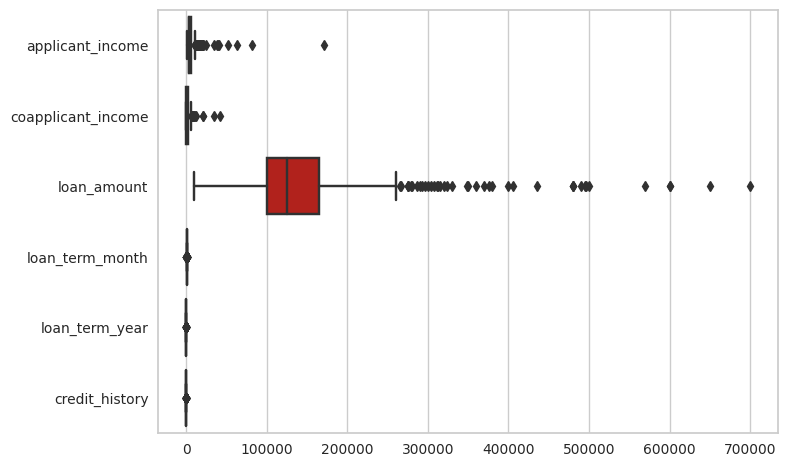

In [44]:
loan_df_num = loan_df.select_dtypes(include='number')
sns.boxplot(loan_df_num,orient='h')

In [45]:
_,loan_df_num.applicant_income = det_hand_iqr(loan_df_num.applicant_income)
_,loan_df_num.coapplicant_income = det_hand_iqr(loan_df_num.coapplicant_income)
_,loan_df_num.loan_amount = det_hand_iqr(loan_df_num.loan_amount)

<Axes: >

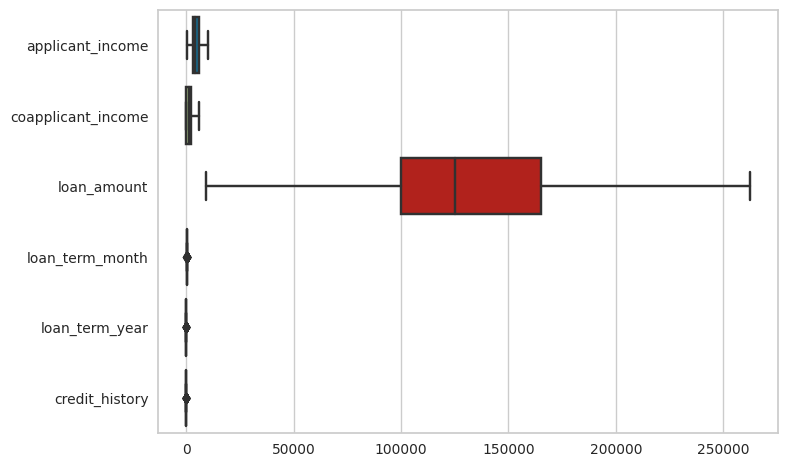

In [46]:
sns.boxplot(loan_df_num,orient='h')

In [47]:
loan_df[loan_df_num.columns.tolist()] = loan_df_num
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000.00,360.00,30.00,1,no,APPROVE,1977-05-15,0,house
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000.00,360.00,30.00,1,no,REJECT,1979-08-24,1,studio
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000.00,360.00,30.00,1,no,APPROVE,1991-03-28,0,house
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000.00,360.00,30.00,1,no,APPROVE,1980-06-02,0,house
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000.00,360.00,30.00,1,no,APPROVE,1989-05-19,0,house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,Female,No,Graduate,No,2900.00,0.00,71000.00,360.00,30.00,1,no,APPROVE,1976-03-25,0,studio
615,LP002979,Male,Yes,Graduate,No,4106.00,0.00,40000.00,180.00,15.00,1,no,APPROVE,1987-01-26,3+,studio
616,LP002983,Male,Yes,Graduate,No,8072.00,240.00,253000.00,360.00,30.00,1,no,APPROVE,1982-03-08,1,house
617,LP002984,Male,Yes,Graduate,No,7583.00,0.00,187000.00,360.00,30.00,1,no,APPROVE,1986-12-05,2,house


## Feature Encoding

In [48]:
round_int_col = ['loan_amount','loan_term_month','loan_term_year']
loan_df[round_int_col] = loan_df[round_int_col].astype('int')
loan_df.head()

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000,360,30,1,no,APPROVE,1977-05-15,0,house
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000,360,30,1,no,REJECT,1979-08-24,1,studio
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000,360,30,1,no,APPROVE,1991-03-28,0,house
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000,360,30,1,no,APPROVE,1980-06-02,0,house
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000,360,30,1,no,APPROVE,1989-05-19,0,house


In [49]:
loan_df_vis = loan_df.copy()

loan_df['birth_date_year'] = loan_df.birth_date.dt.year
loan_df['birth_date_month'] = loan_df.birth_date.dt.month
loan_df['birth_date_day'] = loan_df.birth_date.dt.day

# loan_df_vis = loan_df.copy()
loan_df

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type,birth_date_year,birth_date_month,birth_date_day
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000,360,30,1,no,APPROVE,1977-05-15,0,house,1977,5,15
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000,360,30,1,no,REJECT,1979-08-24,1,studio,1979,8,24
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000,360,30,1,no,APPROVE,1991-03-28,0,house,1991,3,28
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000,360,30,1,no,APPROVE,1980-06-02,0,house,1980,6,2
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000,360,30,1,no,APPROVE,1989-05-19,0,house,1989,5,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,Female,No,Graduate,No,2900.00,0.00,71000,360,30,1,no,APPROVE,1976-03-25,0,studio,1976,3,25
615,LP002979,Male,Yes,Graduate,No,4106.00,0.00,40000,180,15,1,no,APPROVE,1987-01-26,3+,studio,1987,1,26
616,LP002983,Male,Yes,Graduate,No,8072.00,240.00,253000,360,30,1,no,APPROVE,1982-03-08,1,house,1982,3,8
617,LP002984,Male,Yes,Graduate,No,7583.00,0.00,187000,360,30,1,no,APPROVE,1986-12-05,2,house,1986,12,5


In [50]:
loan_df['gender_Male'] = loan_df.gender.apply(lambda x: 1 if (x=='Male') else 0)
loan_df['married_Yes'] = loan_df.married.apply(lambda x: 1 if (x=='Yes') else 0)
loan_df['education_Graduate'] = loan_df.education.apply(lambda x: 1 if (x=='Graduate') else 0)
loan_df['self_employed'] = loan_df.self_employed.apply(lambda x: 1 if (x=='Yes') else 0)
loan_df['has_credit_card'] = loan_df['has_credit_card'].apply(lambda x: 1 if (x=='yes') else 0)
loan_df = loan_df.drop(['gender',
                        'married',
                        'education',
                        'birth_date'
                       ],
                       axis=1
                      )

loan_df = pd.get_dummies(loan_df,columns=['dependents','property_type'])
loan_df

,loan_id,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,...,gender_Male,married_Yes,education_Graduate,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,LP001002,0,5849.00,0.00,100000,360,30,1,0,APPROVE,...,1,0,1,True,False,False,False,False,True,False
1,LP001003,0,4583.00,1508.00,128000,360,30,1,0,REJECT,...,1,1,1,False,True,False,False,False,False,True
2,LP001005,1,3000.00,0.00,66000,360,30,1,0,APPROVE,...,1,1,1,True,False,False,False,False,True,False
3,LP001006,0,2583.00,2358.00,120000,360,30,1,0,APPROVE,...,1,1,0,True,False,False,False,False,True,False
4,LP001008,0,6000.00,0.00,141000,360,30,1,0,APPROVE,...,1,0,1,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,0,2900.00,0.00,71000,360,30,1,0,APPROVE,...,0,0,1,True,False,False,False,False,False,True
615,LP002979,0,4106.00,0.00,40000,180,15,1,0,APPROVE,...,1,1,1,False,False,False,True,False,False,True
616,LP002983,0,8072.00,240.00,253000,360,30,1,0,APPROVE,...,1,1,1,False,True,False,False,False,True,False
617,LP002984,0,7583.00,0.00,187000,360,30,1,0,APPROVE,...,1,1,1,False,False,True,False,False,True,False


# Business Insight

## Analisis minat pelanggan berdasarkan pada tipe properti

### With Groupby

In [51]:
loan_df_grp_gender_prop = loan_df_vis.groupby(['gender','property_type'])['loan_id'].count().reset_index()
loan_df_grp_gender_prop = loan_df_grp_gender_prop.rename({'loan_id':'count'},axis=1)
loan_df_grp_gender_prop

,gender,property_type,count
0,Female,apartment,61
1,Female,house,37
2,Female,studio,27
3,Male,apartment,173
4,Male,house,168
5,Male,studio,152


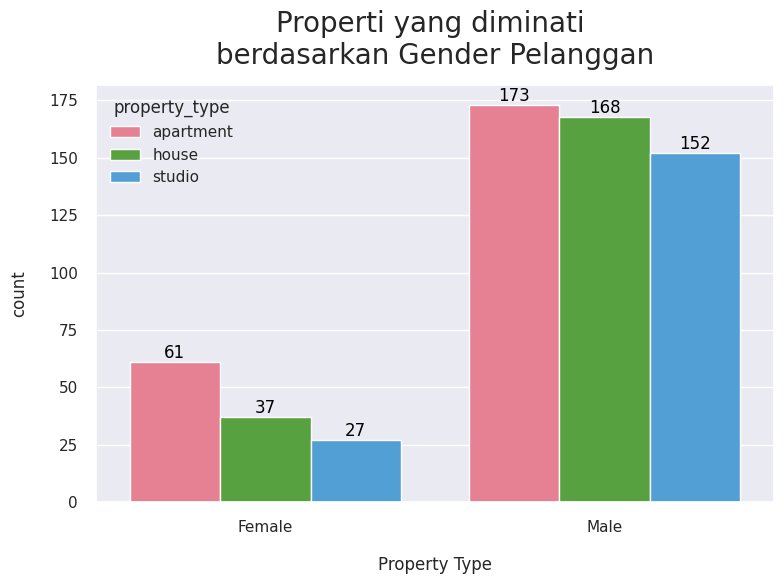

In [52]:
sns.set_theme(context='notebook',
              style='darkgrid'
             )

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.barplot(loan_df_grp_gender_prop,
            x='gender',
            y='count',
            hue='property_type',
            palette='husl'
           )

for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{int(bar_value)}'
    text_x = bar.get_x() + bar.get_width()/2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x,
            text_y,
            text,
            ha='center',
            va='bottom',
            color='black',
            size=12
           )
    
ax.set_xlabel('Property Type',labelpad=15)
ax.set_ylabel('count',labelpad=15)
ax.set_title('Properti yang diminati \nberdasarkan Gender Pelanggan',
             pad=15,
             size=20)
plt.tight_layout()
plt.show()

### Without Groupby

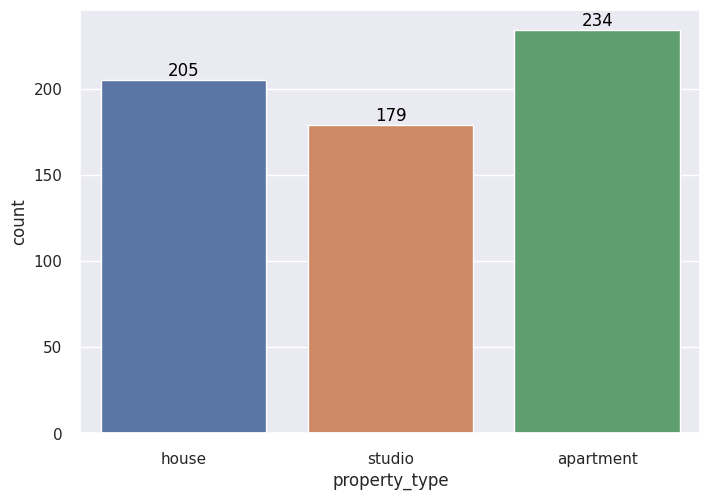

In [53]:
ax = sns.countplot(loan_df_vis,x='property_type')

for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{int(bar_value)}'
    text_x = bar.get_x() + bar.get_width()/2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x,
            text_y,
            text,
            ha='center',
            va='bottom',
            color='black',
            size=12
           )
    
plt.show()

Pelanggan lebih tertarik pada Property 
1. Apartemen
2. House
3. Studio

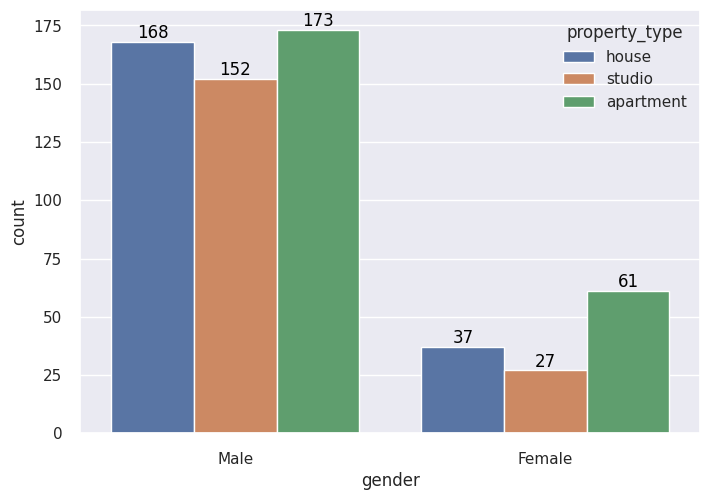

In [54]:
ax = sns.countplot(loan_df_vis, hue='property_type', x='gender')

for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{int(bar_value)}'
    text_x = bar.get_x() + bar.get_width()/2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x,
            text_y,
            text,
            ha='center',
            va='bottom',
            color='black',
            size=12
           )
    
plt.show()


* Ternyata Proposi perempuan terhadap properti lebih banyak dibandingkan yang lain
* Perempuan ternyata lebih menyukai apartemen jika dilihat dari persentase dibandingkan dengan Laki-Laki


In [55]:
def det_gen(x):
    if(x>2010):
        return 'Alfa'
    elif((x>1995) and (x<=2010)):
        return 'Z'
    elif((x>1980) and (x<=1995)):
        return 'Y'
    elif((x>1960) and (x<=1980)):
        return 'X'
    elif((x>1946) and (x<=1960)):
        return 'baby boom'
    elif((x>1925) and (x<=1946)):
        return 'veteran'
    else:
        return 'veteran'

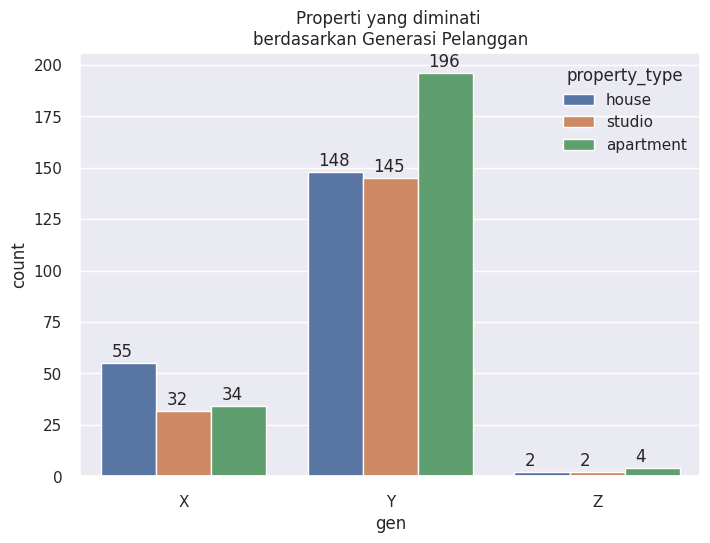

In [56]:
loan_df_vis['gen'] = loan_df_vis.birth_date.dt.year.apply(lambda x:det_gen(x))
loan_df_vis

ax = sns.countplot(loan_df_vis,
                   x='gen',
                   hue='property_type'
                  )

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.05, p.get_height()+3)
               )
plt.title('Properti yang diminati \nberdasarkan Generasi Pelanggan')
plt.show()

In [57]:
loan_df_vis = loan_df_vis.drop('gen',axis=1)
loan_df_vis

,loan_id,gender,married,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,birth_date,dependents,property_type
0,LP001002,Male,No,Graduate,No,5849.00,0.00,100000,360,30,1,no,APPROVE,1977-05-15,0,house
1,LP001003,Male,Yes,Graduate,No,4583.00,1508.00,128000,360,30,1,no,REJECT,1979-08-24,1,studio
2,LP001005,Male,Yes,Graduate,Yes,3000.00,0.00,66000,360,30,1,no,APPROVE,1991-03-28,0,house
3,LP001006,Male,Yes,Not Graduate,No,2583.00,2358.00,120000,360,30,1,no,APPROVE,1980-06-02,0,house
4,LP001008,Male,No,Graduate,No,6000.00,0.00,141000,360,30,1,no,APPROVE,1989-05-19,0,house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,Female,No,Graduate,No,2900.00,0.00,71000,360,30,1,no,APPROVE,1976-03-25,0,studio
615,LP002979,Male,Yes,Graduate,No,4106.00,0.00,40000,180,15,1,no,APPROVE,1987-01-26,3+,studio
616,LP002983,Male,Yes,Graduate,No,8072.00,240.00,253000,360,30,1,no,APPROVE,1982-03-08,1,house
617,LP002984,Male,Yes,Graduate,No,7583.00,0.00,187000,360,30,1,no,APPROVE,1986-12-05,2,house


## Analisis pengaruh status perkawinan terhadap jangka waktu meminjam 

### With Groupby

In [58]:
loan_df_grp_married_tenor = loan_df_vis.groupby(['married','loan_term_year'])['loan_id'].count().reset_index()
loan_df_grp_married_tenor = loan_df_grp_married_tenor.rename({'loan_id':'count'},axis=1)
loan_df_grp_married_tenor.head()

,married,loan_term_year,count
0,No,3,2
1,No,5,1
2,No,10,1
3,No,15,8
4,No,20,2


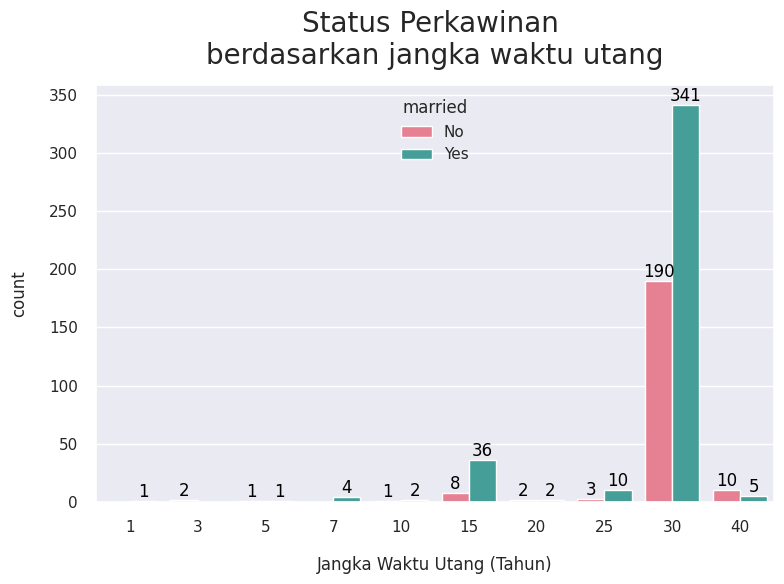

In [59]:
sns.set_theme(context='notebook',
              style='darkgrid'
             )

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.barplot(loan_df_grp_married_tenor,
            hue='married',
            y='count',
            x='loan_term_year',
            palette='husl'
           )

for bar in ax.patches:
    bar_value = bar.get_height()
    try:
        bar_value = int(bar_value)
    except:
        # If conversion fails, handle the case (e.g., set to None or a placeholder)
        bar_value = bar_value  # Or another appropriate value for missing data

    text = f'{bar_value}'
    text_x = bar.get_x() + bar.get_width()/2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x,
            text_y,
            text,
            ha='center',
            va='bottom',
            color='black',
            size=12
           )
    
ax.set_xlabel('Jangka Waktu Utang (Tahun)',labelpad=15)
ax.set_ylabel('count',labelpad=15)
ax.set_title('Status Perkawinan \nberdasarkan jangka waktu utang',
             pad=15,
             size=20)
plt.tight_layout()
plt.show()

### Without Groupby

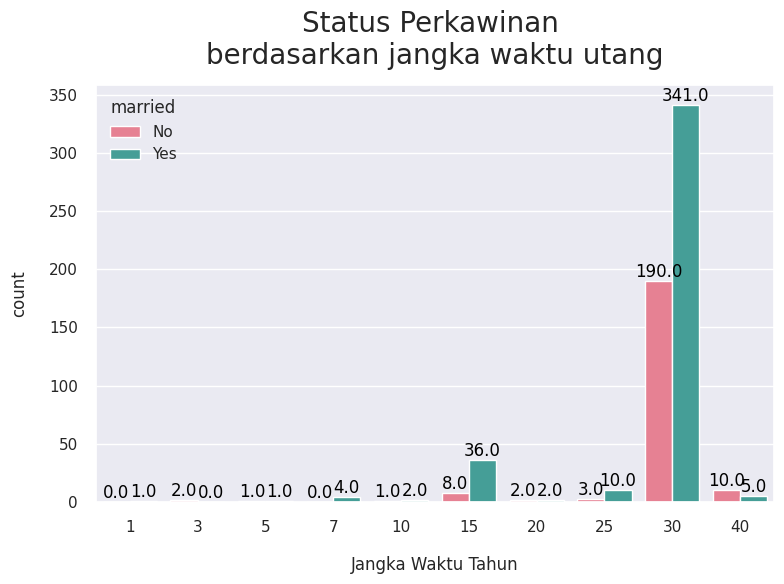

In [60]:
sns.set_theme(context='notebook',
              style='darkgrid'
             )

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.countplot(loan_df_vis,
            hue='married',
            x='loan_term_year',
            palette='husl'
           )

for bar in ax.patches:
    bar_value = bar.get_height()

    text = f'{bar_value}'
    text_x = bar.get_x() + bar.get_width()/2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x,
            text_y,
            text,
            ha='center',
            va='bottom',
            color='black',
            size=12
           )
    
ax.set_xlabel('Jangka Waktu Tahun',labelpad=15)
ax.set_ylabel('count',labelpad=15)
ax.set_title('Status Perkawinan \nberdasarkan jangka waktu utang',
             pad=15,
             size=20)
plt.tight_layout()
plt.show()

In [61]:
bool_col = loan_df.dtypes
bool_col = bool_col[bool_col=='bool'].index.tolist()
loan_df[bool_col] = loan_df[bool_col].astype('int')
loan_df

,loan_id,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,loan_status,...,gender_Male,married_Yes,education_Graduate,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio
0,LP001002,0,5849.00,0.00,100000,360,30,1,0,APPROVE,...,1,0,1,1,0,0,0,0,1,0
1,LP001003,0,4583.00,1508.00,128000,360,30,1,0,REJECT,...,1,1,1,0,1,0,0,0,0,1
2,LP001005,1,3000.00,0.00,66000,360,30,1,0,APPROVE,...,1,1,1,1,0,0,0,0,1,0
3,LP001006,0,2583.00,2358.00,120000,360,30,1,0,APPROVE,...,1,1,0,1,0,0,0,0,1,0
4,LP001008,0,6000.00,0.00,141000,360,30,1,0,APPROVE,...,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002978,0,2900.00,0.00,71000,360,30,1,0,APPROVE,...,0,0,1,1,0,0,0,0,0,1
615,LP002979,0,4106.00,0.00,40000,180,15,1,0,APPROVE,...,1,1,1,0,0,0,1,0,0,1
616,LP002983,0,8072.00,240.00,253000,360,30,1,0,APPROVE,...,1,1,1,0,1,0,0,0,1,0
617,LP002984,0,7583.00,0.00,187000,360,30,1,0,APPROVE,...,1,1,1,0,0,1,0,0,1,0


# Machine Learning Unsupervised

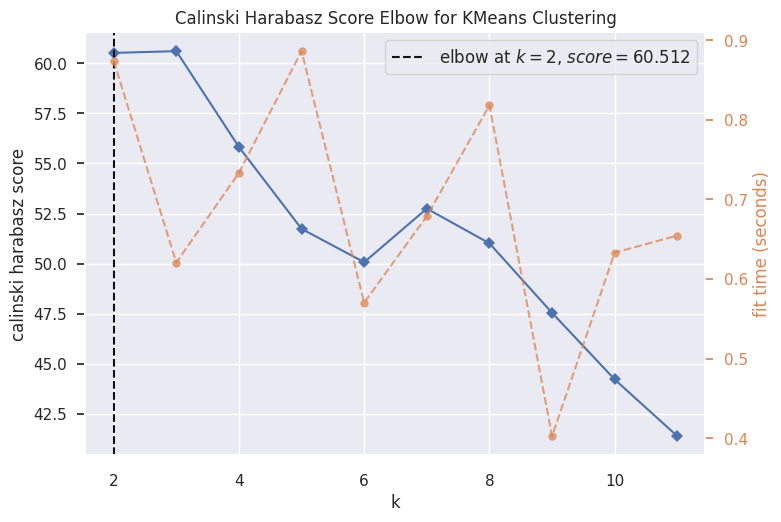

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [62]:
loan_df_uns = loan_df.drop(['loan_id','loan_status'],axis=1)
#loan_df_uns_non = loan_df_uns.copy()
stscal = StandardScaler()
all_col = loan_df_uns.columns.tolist()
loan_df_uns = stscal.fit_transform(loan_df_uns)
loan_df_uns = pd.DataFrame(loan_df_uns,columns=all_col)

kmeansku = KMeans(random_state=42)
visualelb = KElbowVisualizer(kmeansku,
                             k=(2,12),
                             metric='calinski_harabasz'
                            )
visualelb.fit(loan_df_uns)
visualelb.show()

In [63]:
kmeansku = KMeans(4,random_state=42)
kmeansku.fit(loan_df_uns)
clus_ser = kmeansku.predict(loan_df_uns)
clus_ser = pd.Series(clus_ser,name='Cluster')

all_col = loan_df_uns.columns.tolist()

loan_df_uns = stscal.inverse_transform(loan_df_uns)
loan_df_uns = pd.DataFrame(loan_df_uns,columns=all_col)
loan_df_uns = pd.concat([loan_df_uns,clus_ser],axis=1)
loan_df_uns

,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,birth_date_year,birth_date_month,...,married_Yes,education_Graduate,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio,Cluster
0,0.00,5849.00,0.00,100000.00,360.00,30.00,1.00,0.00,1977.00,5.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1
1,0.00,4583.00,1508.00,128000.00,360.00,30.00,1.00,0.00,1979.00,8.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0
2,1.00,3000.00,0.00,66000.00,360.00,30.00,1.00,0.00,1991.00,3.00,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1
3,0.00,2583.00,2358.00,120000.00,360.00,30.00,1.00,0.00,1980.00,6.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1
4,0.00,6000.00,0.00,141000.00,360.00,30.00,1.00,0.00,1989.00,5.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,0.00,2900.00,0.00,71000.00,360.00,30.00,1.00,0.00,1976.00,3.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1
615,0.00,4106.00,0.00,40000.00,180.00,15.00,1.00,0.00,1987.00,1.00,...,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2
616,0.00,8072.00,240.00,253000.00,360.00,30.00,1.00,0.00,1982.00,3.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0
617,0.00,7583.00,0.00,187000.00,360.00,30.00,1.00,0.00,1986.00,12.00,...,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,3


In [64]:
loan_df_uns_0 = loan_df_uns[loan_df_uns.Cluster==0]
loan_df_uns_1 = loan_df_uns[loan_df_uns.Cluster==1]
loan_df_uns_2 = loan_df_uns[loan_df_uns.Cluster==2]
loan_df_uns_3 = loan_df_uns[loan_df_uns.Cluster==3]

In [65]:
loan_df_uns_0.describe().T

,count,mean,std,min,25%,50%,75%,max
self_employed,140.00,0.19,0.39,0.00,0.00,0.00,0.00,1.00
applicant_income,140.00,5247.67,2691.43,1000.00,3147.50,4594.50,6401.50,10222.75
coapplicant_income,140.00,1312.14,1549.01,0.00,0.00,1057.50,2103.75,5731.25
loan_amount,140.00,151307.14,61492.19,26000.00,104750.00,138000.00,185250.00,262500.00
loan_term_month,140.00,360.00,17.63,300.00,360.00,360.00,360.00,480.00
loan_term_year,140.00,30.00,1.47,25.00,30.00,30.00,30.00,40.00
credit_history,140.00,0.75,0.43,-0.00,0.75,1.00,1.00,1.00
has_credit_card,140.00,0.09,0.28,0.00,0.00,0.00,0.00,1.00
birth_date_year,140.00,1985.28,4.97,1967.00,1982.00,1985.00,1988.25,2000.00
birth_date_month,140.00,6.66,3.56,1.00,3.00,7.00,10.00,12.00


In [66]:
loan_df_uns_1.describe().T

,count,mean,std,min,25%,50%,75%,max
self_employed,328.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
applicant_income,328.00,4331.00,2396.41,150.00,2595.75,3555.50,5491.00,10222.75
coapplicant_income,328.00,1419.47,1607.98,0.00,0.00,1250.00,2344.50,5731.25
loan_amount,328.00,130432.93,52347.61,9000.00,99750.00,120000.00,154000.00,262500.00
loan_term_month,328.00,362.93,23.28,300.00,360.00,360.00,360.00,480.00
loan_term_year,328.00,30.24,1.94,25.00,30.00,30.00,30.00,40.00
credit_history,328.00,0.84,0.37,-0.00,1.00,1.00,1.00,1.00
has_credit_card,328.00,0.05,0.22,0.00,0.00,0.00,0.00,1.00
birth_date_year,328.00,1984.35,5.24,1967.00,1981.00,1985.00,1988.00,1996.00
birth_date_month,328.00,6.01,3.32,1.00,3.00,6.00,9.00,12.00


In [67]:
loan_df_uns_2.describe().T

,count,mean,std,min,25%,50%,75%,max
self_employed,59.00,0.14,0.35,0.00,0.00,0.00,0.00,1.00
applicant_income,59.00,4742.44,2632.23,416.00,2982.50,3716.00,6150.00,10222.75
coapplicant_income,59.00,1495.74,1877.31,0.00,0.00,461.00,2851.00,5731.25
loan_amount,59.00,122525.42,57878.84,17000.00,80500.00,115000.00,155000.00,262500.00
loan_term_month,59.00,161.69,48.63,12.00,180.00,180.00,180.00,240.00
loan_term_year,59.00,13.47,4.05,1.00,15.00,15.00,15.00,20.00
credit_history,59.00,0.81,0.39,-0.00,1.00,1.00,1.00,1.00
has_credit_card,59.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00
birth_date_year,59.00,1985.25,5.53,1970.00,1983.00,1986.00,1988.50,1997.00
birth_date_month,59.00,5.90,3.44,1.00,3.00,5.00,9.00,12.00


In [68]:
loan_df_uns_3.describe().T

,count,mean,std,min,25%,50%,75%,max
self_employed,92.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
applicant_income,92.00,4719.50,2282.74,210.00,3254.75,4088.00,5948.83,10222.75
coapplicant_income,92.00,1490.40,1628.54,0.00,0.00,1405.50,2008.75,5731.25
loan_amount,92.00,147505.43,53981.96,45000.00,110000.00,132500.00,185500.00,262500.00
loan_term_month,92.00,359.35,24.35,240.00,360.00,360.00,360.00,480.00
loan_term_year,92.00,29.95,2.03,20.00,30.00,30.00,30.00,40.00
credit_history,92.00,0.82,0.39,-0.00,1.00,1.00,1.00,1.00
has_credit_card,92.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00
birth_date_year,92.00,1985.21,4.64,1972.00,1983.00,1985.00,1988.00,1998.00
birth_date_month,92.00,6.33,3.30,1.00,3.00,6.00,9.00,12.00


# Machine Learning Supervised

## Oversampling

<Axes: xlabel='loan_status', ylabel='count'>

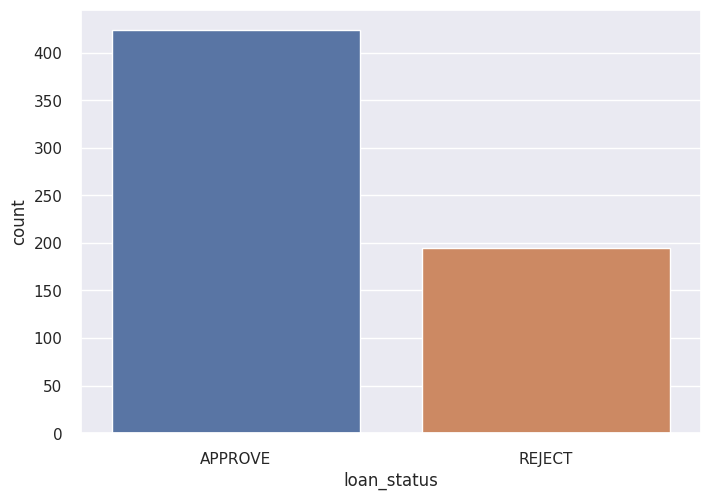

In [69]:
sns.countplot(loan_df,x='loan_status')

In [70]:

X = loan_df.drop(['loan_status','loan_id'],axis=1)
y = loan_df['loan_status']

smoteku = SMOTE()
X_res, y_res = smoteku.fit_resample(X, y)
print((X_res, y_res))

(     self_employed  applicant_income  coapplicant_income  loan_amount  \
0                0           5849.00                0.00       100000   
1                0           4583.00             1508.00       128000   
2                1           3000.00                0.00        66000   
3                0           2583.00             2358.00       120000   
4                0           6000.00                0.00       141000   
..             ...               ...                 ...          ...   
843              0           3321.59             1202.64       103645   
844              0           3649.75             1771.78       148367   
845              0           3831.76             2710.52       110000   
846              0           2890.60              238.29        88406   
847              0           3642.18             3042.62       151385   

     loan_term_month  loan_term_year  credit_history  has_credit_card  \
0                360              30             

## Without Feature Engineering

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X_res,
                                                 y_res,
                                                 test_size=0.2,
                                                 random_state=42
                                                )
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     APPROVE       0.79      0.94      0.86        71
      REJECT       0.95      0.82      0.88        99

    accuracy                           0.87       170
   macro avg       0.87      0.88      0.87       170
weighted avg       0.88      0.87      0.87       170



<Axes: xlabel='feature importance', ylabel='feature name'>

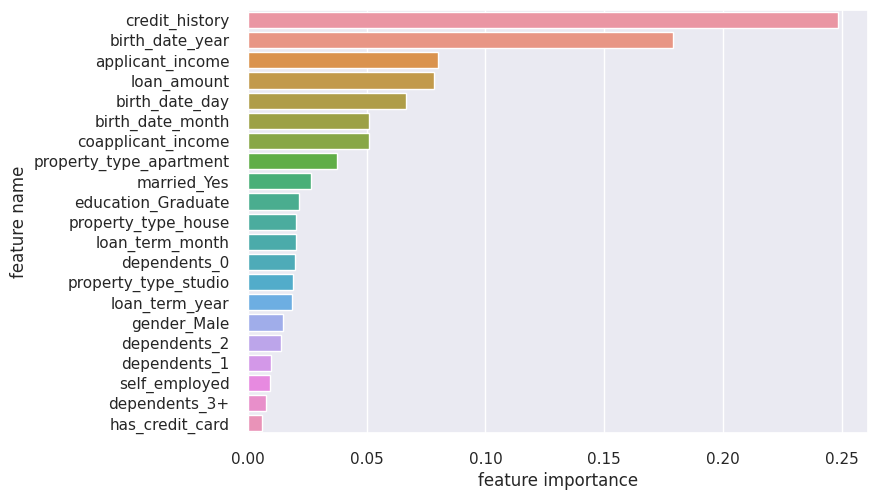

In [72]:
mi_df = pd.DataFrame({'feature name':rfc.feature_names_in_,
                      'feature importance':rfc.feature_importances_
                     })
mi_df = mi_df.sort_values('feature importance',ascending=False)
sns.barplot(mi_df,
            y='feature name',
            x='feature importance'
           )

## With Feature Engineering

In [73]:
X_train['total_income'] = X_train['applicant_income'] + X_train['coapplicant_income']
#X_train['loan_per_month'] = X_train['loan_amount'] / X_train['loan_term_month']
#X_train['age'] = 2024 -  X_train['birth_date_year']

X_train = X_train.drop(['applicant_income',
                        'coapplicant_income',
                        'loan_term_year',
                        #'birth_date_year',
                        #'birth_date_month',
                        #'birth_date_day',
                        
                        #'loan_amount',
                        #'loan_term_month',
                       ],
                       axis=1)
X_train

,self_employed,loan_amount,loan_term_month,credit_history,has_credit_card,birth_date_year,birth_date_month,birth_date_day,gender_Male,married_Yes,education_Graduate,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio,total_income
598,0,110000,360,1,0,1983,1,24,1,0,0,1,0,0,0,0,0,1,3833.00
649,0,115913,360,0,0,1988,4,13,1,0,0,1,0,0,0,0,0,1,6115.61
280,1,158000,360,0,0,1990,8,22,1,0,0,0,1,0,0,0,1,0,6479.00
2,1,66000,360,1,0,1991,3,28,1,1,1,1,0,0,0,0,1,0,3000.00
752,0,77102,360,0,0,1979,5,22,0,0,1,1,0,0,0,0,1,0,3534.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,97000,360,1,0,1986,1,13,1,1,0,0,0,1,0,1,0,0,3750.00
106,0,225000,360,1,0,1994,10,4,1,1,1,0,0,1,0,0,1,0,11348.75
270,0,30000,360,1,0,1982,7,26,0,0,1,1,0,0,0,0,1,0,3237.00
435,0,262500,360,1,0,1988,7,26,1,0,1,1,0,0,0,1,0,0,10222.75


In [74]:
X_test['total_income'] = X_test['applicant_income'] + X_test['coapplicant_income']
#X_test['loan_per_month'] = X_test['loan_amount'] / X_test['loan_term_month']
#X_test['age'] = 2024 -  X_test['birth_date_year']


X_test = X_test.drop(['applicant_income',
                      'coapplicant_income',
                      'loan_term_year',
                      #'birth_date_year',
                      #'birth_date_month',
                      #'birth_date_day',

                      #'loan_amount',
                      #'loan_term_month',
                     ],
                     axis=1)
X_test

,self_employed,loan_amount,loan_term_month,credit_history,has_credit_card,birth_date_year,birth_date_month,birth_date_day,gender_Male,married_Yes,education_Graduate,dependents_0,dependents_1,dependents_2,dependents_3+,property_type_apartment,property_type_house,property_type_studio,total_income
664,0,65797,312,0,0,1988,2,11,1,0,1,0,0,0,0,0,0,0,2181.99
363,0,236000,360,1,0,1980,7,13,1,1,1,0,0,1,0,1,0,0,8667.00
110,0,136000,360,1,0,1980,4,23,1,0,1,1,0,0,0,0,1,0,5316.00
678,1,85391,360,1,0,1985,5,9,1,0,0,1,0,0,0,0,0,0,7147.62
39,0,110000,360,1,0,1996,6,28,1,0,0,1,0,0,0,1,0,0,5416.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,127000,360,0,0,1980,6,6,1,0,1,0,0,0,0,1,0,0,3983.19
155,0,262500,180,0,0,1987,1,23,1,1,1,0,0,0,1,1,0,0,10222.75
490,0,262500,360,1,0,1979,3,2,1,1,1,0,1,0,0,0,1,0,10222.75
101,0,151000,360,1,0,1988,8,28,1,0,1,1,0,0,0,1,0,0,8649.00


In [75]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     APPROVE       0.79      0.96      0.87        71
      REJECT       0.96      0.82      0.89        99

    accuracy                           0.88       170
   macro avg       0.88      0.89      0.88       170
weighted avg       0.89      0.88      0.88       170



<Axes: xlabel='feature importance', ylabel='feature name'>

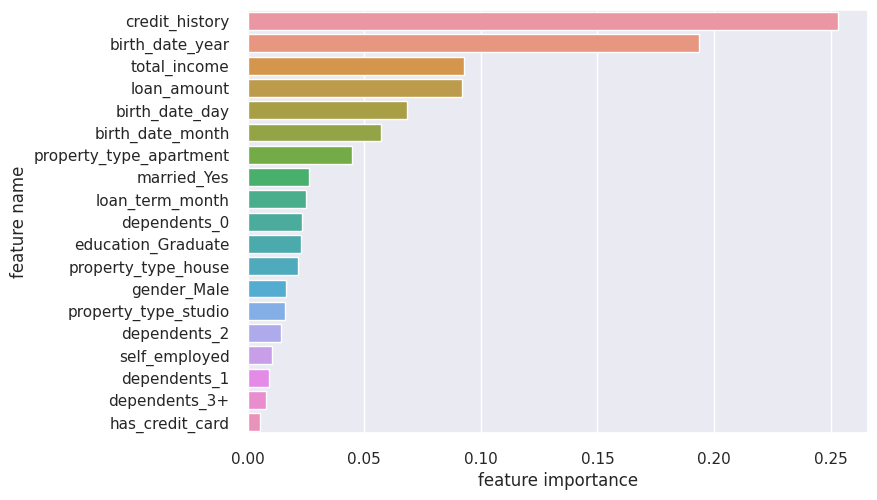

In [76]:
mi_df = pd.DataFrame({'feature name':rfc.feature_names_in_,
                      'feature importance':rfc.feature_importances_
                     })
mi_df = mi_df.sort_values('feature importance',ascending=False)
sns.barplot(mi_df,
            y='feature name',
            x='feature importance'
           )